# IMPORTS

In [109]:
!pip install lightgbm
!pip install pandas_ta
# !pip install pandas_ta --no-index --find-links=file:///kaggle/input/pandas-ta/

In [110]:
import pandas as pd
import numpy as np
import random
from lightgbm import LGBMRegressor
import pandas_ta as ta
import os

# CONSTANTS

In [111]:
NUMBER_OF_STABLE_STOCKS = 370
NUMBER_OF_DAILY_CHOSEN_STOCKS = 15
DAYS_PERIODS = [10, 21, 63]

# PROCESS DATA

Submission format: our end goal

In [112]:
# sample_submission = pd.read_csv(
#     r'../input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv')
# sample_submission

In [113]:
train_stock_prices = pd.read_csv(
    os.path.join('../input/jpx-tokyo-stock-exchange-prediction/train_files', 'stock_prices.csv'))
supplemental_stock_prices = pd.read_csv(
    os.path.join('../input/jpx-tokyo-stock-exchange-prediction/supplemental_files', 'stock_prices.csv'))

In [114]:
stock_prices = pd.concat([train_stock_prices, supplemental_stock_prices])

In [115]:
delisted_stocks = stock_prices[stock_prices['SupervisionFlag'] == True]['SecuritiesCode'].values

In [116]:
def get_stocks_traded_every_day(stock_prices_df):
    """Return stocks that are traded in every trading day in data and remove others"""
    traded_stock_per_date = stock_prices_df['Date'].value_counts()
    stocks_by_descending_trade_count = stock_prices_df['SecuritiesCode'].value_counts()
    return stocks_by_descending_trade_count[stocks_by_descending_trade_count == len(traded_stock_per_date)].index.values


daily_traded_stocks = get_stocks_traded_every_day(stock_prices)

In [117]:
# TODO: make set and subtract
daily_traded_stocks = [x for x in daily_traded_stocks if (x not in delisted_stocks)]
print(
    f'We now have {len(daily_traded_stocks)} stocks which have available information in every trading day and which are NOT delisted.\n'
    'These remaining stocks are the ones we are going to analyze and "play" with from now on.')

We now have 1845 stocks which have available information in every trading day and which are NOT delisted.
These remaining stocks are the ones we are going to analyze and "play" with from now on.


In [118]:
listed_stock_prices = stock_prices.loc[
    stock_prices['SecuritiesCode'].isin(daily_traded_stocks), ['Date', 'SecuritiesCode', 'Open', 'Close', 'Volume',
                                                               'AdjustmentFactor', 'Target']]

# 1850 daily-traded & listed stocks * 1202 trading days == 2223700 rows
assert len(listed_stock_prices) == len(daily_traded_stocks) * len(stock_prices['Date'].unique())

In [119]:
def adjust_price(price):
    def calculate_adjusted(df):
        """apply AdjustmentFactor on columns"""
        new = df.sort_index(ascending=False)
        split_coef = new['AdjustmentFactor'].shift(1).fillna(1).cumprod()
        new['adj_open'] = new['Open'] / split_coef
        new['adj_close'] = new['Close'] / split_coef
        new['adj_volume'] = split_coef * new['Volume']
        return new.sort_index(ascending=True)

    price = price.groupby('SecuritiesCode').apply(calculate_adjusted).reset_index(drop=True)
    price.set_index('Date', inplace=True)

    return price

In [120]:
adj_prices_df = adjust_price(listed_stock_prices)

# TODO: change "adj_open"!
adj_prices_df['daily_change'] = (adj_prices_df['adj_close'] - adj_prices_df['adj_open']) / adj_prices_df['adj_close']
adj_prices_df = adj_prices_df.reset_index()
# adj_prices_df

In [121]:
adj_prices_df

,Date,SecuritiesCode,Open,Close,Volume,AdjustmentFactor,Target,adj_open,adj_close,adj_volume,daily_change
0,2017-01-04,1301,2734.0,2742.0,31400,1.0,0.000730,2734.0,2742.0,31400.0,0.002918
1,2021-12-06,1301,2982.0,2971.0,8900,1.0,-0.003263,2982.0,2971.0,8900.0,-0.003702
2,2017-01-05,1301,2743.0,2738.0,17900,1.0,0.002920,2743.0,2738.0,17900.0,-0.001826
3,2021-12-07,1301,2998.0,3065.0,19100,1.0,0.009820,2998.0,3065.0,19100.0,0.021860
4,2017-01-06,1301,2734.0,2740.0,19900,1.0,-0.001092,2734.0,2740.0,19900.0,0.002190
...,...,...,...,...,...,...,...,...,...,...,...
2429860,2021-11-29,9997,678.0,668.0,320800,1.0,0.026987,678.0,668.0,320800.0,-0.014970
2429861,2021-11-30,9997,670.0,667.0,296300,1.0,-0.001460,670.0,667.0,296300.0,-0.004498
2429862,2021-12-01,9997,661.0,685.0,339100,1.0,0.017544,661.0,685.0,339100.0,0.035036
2429863,2021-12-02,9997,681.0,684.0,342900,1.0,0.014368,681.0,684.0,342900.0,0.004386


In [122]:
grouped_df = adj_prices_df.groupby('Date')['daily_change'].mean()
grouped_df = pd.DataFrame(grouped_df)
grouped_df.columns = ['market_change_mean']
# grouped_df

In [123]:
grouped_df

,market_change_mean
Date,
2017-01-04,0.013806
2017-01-05,0.001261
2017-01-06,0.006517
2017-01-10,-0.001973
2017-01-11,-0.001397
...,...
2022-05-23,0.003415
2022-05-24,-0.011786
2022-05-25,-0.005785


In [124]:
all_stocks_df = adj_prices_df.join(grouped_df, on='Date')
all_stocks_df['market_gap'] = all_stocks_df['daily_change'] - all_stocks_df['market_change_mean']
all_stocks_df.sort_values(by='Date', inplace=True)
# all_stocks_df.head()

In [125]:
# all_stocks_df[all_stocks_df['SecuritiesCode'] == 1301]['market_gap'].std()

In [126]:
# all_stocks_df[all_stocks_df['SecuritiesCode'] == 1301].reset_index().plot(x='Date',
#                                                                            y=["daily_change", "market_change_mean"],
#                                                                            kind="line", figsize=(20, 10))

In [127]:
statistics_df = all_stocks_df.groupby(by='SecuritiesCode')['market_gap'].agg(['mean', 'median', 'std'])
statistics_df['abs_mean'] = np.abs(statistics_df['mean'])
statistics_df

,mean,median,std,abs_mean
SecuritiesCode,,,,
1301,0.000341,0.000216,0.010013,0.000341
1332,0.000006,-0.000586,0.013794,0.000006
1333,0.000163,-0.000245,0.011128,0.000163
1376,-0.001907,-0.001430,0.015421,0.001907
1377,0.000093,-0.000265,0.011549,0.000093
...,...,...,...,...
9990,-0.000526,-0.000648,0.014341,0.000526
9991,-0.000268,-0.000688,0.012211,0.000268
9993,-0.000424,-0.000333,0.011470,0.000424


<AxesSubplot:>

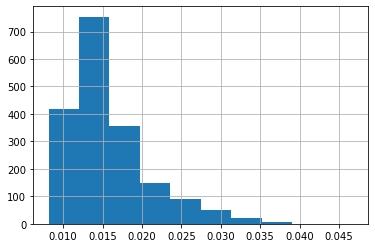

In [128]:
statistics_df['std'].hist()

The stocks with std around 0 (+-) are those that behave LIKE THE MARKET.
We want them to be part of our prediction because they are the least-noisy stocks.

In [129]:
statistics_df.sort_values(by=['abs_mean', 'std'], ascending=True, inplace=True)
statistics_df

,mean,median,std,abs_mean
SecuritiesCode,,,,
9099,6.895782e-07,-0.000590,0.018053,6.895782e-07
6539,-8.960286e-07,-0.000303,0.022553,8.960286e-07
8237,1.058401e-06,0.000164,0.018164,1.058401e-06
2109,-2.032267e-06,-0.000494,0.010513,2.032267e-06
7921,-2.204802e-06,-0.000640,0.010946,2.204802e-06
...,...,...,...,...
3825,-2.435402e-03,-0.004819,0.046765,2.435402e-03
5918,2.451289e-03,0.001119,0.012953,2.451289e-03
4308,-2.554354e-03,-0.002169,0.030815,2.554354e-03


In [130]:
stable_stocks_statistics_df = statistics_df[:NUMBER_OF_STABLE_STOCKS]

In [131]:
# TODO: do we use this DF later? probably unnecessary
stable_stocks_df = all_stocks_df[all_stocks_df['SecuritiesCode'].isin(stable_stocks_statistics_df.index)]
stable_stocks_df

,Date,SecuritiesCode,Open,Close,Volume,AdjustmentFactor,Target,adj_open,adj_close,adj_volume,daily_change,market_change_mean,market_gap
331884,2017-01-04,2768,289.0,293.0,10209000,1.0,0.003436,57.8,58.6,51045000.0,0.013652,0.013806,-0.000154
1954428,2017-01-04,8255,4065.0,4130.0,15500,1.0,0.003632,4065.0,4130.0,15500.0,0.015738,0.013806,0.001932
1953111,2017-01-04,8253,2099.0,2124.0,1232800,1.0,-0.001864,2099.0,2124.0,1232800.0,0.011770,0.013806,-0.002036
1951794,2017-01-04,8252,1714.0,1760.0,1208100,1.0,0.001716,1714.0,1760.0,1208100.0,0.026136,0.013806,0.012330
1947843,2017-01-04,8242,1811.0,1834.0,440700,1.0,-0.002118,1811.0,1834.0,440700.0,0.012541,0.013806,-0.001265
...,...,...,...,...,...,...,...,...,...,...,...,...,...
471722,2022-05-27,3264,178.0,176.0,88100,1.0,0.011299,178.0,176.0,88100.0,-0.011364,-0.004496,-0.006868
1297481,2022-05-27,6417,4315.0,4265.0,221000,1.0,0.003517,4315.0,4265.0,221000.0,-0.011723,-0.004496,-0.007228
293927,2022-05-27,2664,2047.0,2032.0,47500,1.0,-0.009709,2047.0,2032.0,47500.0,-0.007382,-0.004496,-0.002886
1833500,2022-05-27,8014,1942.0,1956.0,13600,1.0,-0.006042,1942.0,1956.0,13600.0,0.007157,-0.004496,0.011653


In [132]:
assert stable_stocks_df.SecuritiesCode.nunique() == NUMBER_OF_STABLE_STOCKS

Get all non-stable stocks:
These are the stocks from which we want to get the ones which are better/worse than the market

In [133]:
extreme_stocks = statistics_df[(NUMBER_OF_STABLE_STOCKS + 1):]

"Top": the stocks which are usually "better" then the market in terms of daily_change (on average)
"Bottom": the stocks which are usually "worse" then the market in terms of daily_change (on average)

In [134]:
top_stocks = extreme_stocks[extreme_stocks['mean'] > 0].sort_values(by=['std'], ascending=True).index.unique()
bottom_stocks = extreme_stocks[extreme_stocks['mean'] < 0].sort_values(by=['std'], ascending=True).index.unique()
top_stocks_df = all_stocks_df[all_stocks_df['SecuritiesCode'].isin(top_stocks)]
bottom_stocks_df = all_stocks_df[all_stocks_df['SecuritiesCode'].isin(bottom_stocks)]

In [135]:
print(f'There are {len(top_stocks)} top_stocks and {len(bottom_stocks)} bottom_stocks')

There are 794 top_stocks and 680 bottom_stocks


In [136]:
top_stocks_df = top_stocks_df.set_index('Date')
bottom_stocks_df = bottom_stocks_df.set_index('Date')

In [137]:
def get_features_for_prediction(df, code):
    """
    Args:
        df (pd.DataFrame)  : pd.DataFrame include stock_price
        code (int)  : A local code for a listed company
    Returns:
        feats DataFrame (pd.DataFrame)
    """
    # close_col = "adj_close"
    feats = df.loc[df['SecuritiesCode'] == code, ['SecuritiesCode', 'Target', 'adj_close', 'adj_volume']].copy()

    for period in DAYS_PERIODS:
        feats[f'return_{period}_days'] = feats['adj_close'].pct_change(period)
        feats[f'volume_{period}_days'] = feats['adj_volume'].pct_change(period)
        feats[f'ema_{period}_days'] = ta.ema(feats['adj_close'], length=period)

    # drop Close column
    #feats = feats.drop(['adj_close'], axis=1)

    # filling data for nan and inf
    feats['adj_volume'] = feats['adj_volume'].fillna(0)
    feats = feats.replace([np.inf, -np.inf], 0)

    return feats

## Generate features:

In [138]:
features = []

for i in [top_stocks_df, bottom_stocks_df]:
    # .reset_index().sort_values(by=['Date', 'SecuritiesCode'], inplace=True)
    result = pd.concat([get_features_for_prediction(i, code) for code in i['SecuritiesCode'].unique()])
    result.reset_index().sort_values(by=['Date', 'SecuritiesCode'], inplace=True)
    features.append(result)

top_features_df = features[0]
bottom_features_df = features[1]

In [139]:
top_features_df

,SecuritiesCode,Target,adj_close,adj_volume,return_10_days,volume_10_days,ema_10_days,return_21_days,volume_21_days,ema_21_days,return_63_days,volume_63_days,ema_63_days
Date,,,,,,,,,,,,,
2017-01-04,1301,0.000730,2742.0,31400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,1301,0.002920,2738.0,17900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,1301,-0.001092,2740.0,19900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,1301,-0.005100,2748.0,24200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,1301,-0.003295,2745.0,9300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,4062,-0.002144,4785.0,699000.0,0.029032,-0.449650,4784.890156,-0.095463,0.047976,4928.624842,-0.153097,-0.212926,5370.428429
2022-05-24,4062,-0.025779,4665.0,948800.0,0.020788,-0.256077,4763.091946,-0.160971,-0.200607,4904.658947,-0.194301,-0.159908,5348.383791
2022-05-25,4062,0.008820,4655.0,763400.0,0.005400,-0.168772,4743.438865,-0.152095,-0.100189,4881.962679,-0.187609,-0.124742,5326.715547


# MODEL

In [140]:
LGBM_PARAMS = {
    'seed': 42,
    'n_jobs': -1,
}

FEAT_COLS = [
    'return_10_days',
    'volume_10_days',
    'ema_10_days',
    'return_21_days',
    'volume_21_days',
    'ema_21_days',
    'return_63_days',
    'volume_63_days',
    'ema_63_days'
]

In [141]:
def get_features_and_label(df):
    """
    Args:
        df (pd.DataFrame): loaded price data with features
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # split data into TRAIN and TEST
    TRAIN_END = "2021-12-03"
    # We put a week gap between TRAIN_END and TEST_START
    # to avoid leakage of test data information from label
    TEST_START = "2021-12-06"

    # to store splited data
    trains_X, tests_X = [], []
    trains_y, tests_y = [], []

    # generate feature one by one
    for code in df['SecuritiesCode'].unique():
        feats = df[df['SecuritiesCode'] == code].dropna().drop(columns='Target')
        labels = df.loc[df['SecuritiesCode'] == code, ['SecuritiesCode', 'Target']].dropna()

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # align label and feature indexes
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]

            assert (labels.loc[:, 'SecuritiesCode'] == feats.loc[:, 'SecuritiesCode']).all()
            labels = labels['Target']

            # split data into TRAIN and TEST
            _train_X = feats[:TRAIN_END]
            _test_X = feats[TEST_START:]

            _train_y = labels[:TRAIN_END]
            _test_y = labels[TEST_START:]

            assert len(_train_X) == len(_train_y)
            assert len(_test_X) == len(_test_y)

            # store features
            trains_X.append(_train_X)
            tests_X.append(_test_X)
            # store labels
            trains_y.append(_train_y)
            tests_y.append(_test_y)

    # combine features for each codes
    train_X = pd.concat(trains_X)
    test_X = pd.concat(tests_X)
    # combine label for each codes
    train_y = pd.concat(trains_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, test_X, test_y

In [142]:
def set_rank(df):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with rank
    """
    # set 'Rank' starting from 0
    df.loc[:, 'Rank'] = np.arange(len(df))
    return df

In [143]:
def get_daily_ranked_results(df: pd.DataFrame, predict_sort_ascending: bool) -> pd.DataFrame:
    # generate feature/label
    train_X, train_y, test_X, test_y = get_features_and_label(df)
    # initialize model
    pred_model = LGBMRegressor(**LGBM_PARAMS)
    # train
    pred_model.fit(train_X[FEAT_COLS].values, train_y)
    # prepare result data
    result = test_X[['SecuritiesCode']].copy()
    # predict
    result.loc[:, 'predict'] = pred_model.predict(test_X[FEAT_COLS])
    # actual result
    result.loc[:, 'Target'] = test_y.values
    # sort results by date and ascending/descending "predict", depending on which group we want:
    # the higher the "predict" the more likely to BUY the stock
    # the lower the "predict" the more likely to SELL the stock
    result = result.reset_index().sort_values(['Date', 'predict'], ascending=[True, predict_sort_ascending])
    # set_rank
    ranked_results = result.groupby('Date').apply(set_rank)
    # Drop unnecessary columns. Keep only those which are relevant for submission:
    ranked_results_no_labels_df = ranked_results.reset_index(drop=True).drop(columns=['predict'])

    return ranked_results_no_labels_df.groupby('Date').head(NUMBER_OF_DAILY_CHOSEN_STOCKS)

In [144]:
top_daily_chosen_stocks_df = get_daily_ranked_results(top_features_df, predict_sort_ascending=False)
bottom_daily_chosen_stocks_df = get_daily_ranked_results(bottom_features_df, predict_sort_ascending=True)

In [145]:
top_daily_chosen_stocks_df

,Date,SecuritiesCode,Target,Rank
0,2021-12-06,5713,0.006755,0
1,2021-12-06,9303,-0.021761,1
2,2021-12-06,5393,-0.004671,2
3,2021-12-06,5192,-0.000971,3
4,2021-12-06,1939,0.003014,4
...,...,...,...,...
90079,2022-05-27,7747,-0.003071,10
90080,2022-05-27,9104,-0.033661,11
90081,2022-05-27,7205,0.011268,12
90082,2022-05-27,3349,0.006601,13


## Split stable_stocks_statistics_df randomly to 2 groups each with (NUMBER_OF_STABLE_STOCKS / 2) stocks

In [146]:
def random_split_of_list_into_halves(l: list) -> [list, list]:
    random.shuffle(l)
    return l[:int(len(l) / 2)], l[int(len(l) / 2):]

## Concat top_daily_chosen_stocks_df + stable half + stable half + bottom_daily_chosen_stocks_df

In [147]:
stable_stocks_df = stable_stocks_df.set_index('Date')
stable_stocks_df

,SecuritiesCode,Open,Close,Volume,AdjustmentFactor,Target,adj_open,adj_close,adj_volume,daily_change,market_change_mean,market_gap
Date,,,,,,,,,,,,
2017-01-04,2768,289.0,293.0,10209000,1.0,0.003436,57.8,58.6,51045000.0,0.013652,0.013806,-0.000154
2017-01-04,8255,4065.0,4130.0,15500,1.0,0.003632,4065.0,4130.0,15500.0,0.015738,0.013806,0.001932
2017-01-04,8253,2099.0,2124.0,1232800,1.0,-0.001864,2099.0,2124.0,1232800.0,0.011770,0.013806,-0.002036
2017-01-04,8252,1714.0,1760.0,1208100,1.0,0.001716,1714.0,1760.0,1208100.0,0.026136,0.013806,0.012330
2017-01-04,8242,1811.0,1834.0,440700,1.0,-0.002118,1811.0,1834.0,440700.0,0.012541,0.013806,-0.001265
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27,3264,178.0,176.0,88100,1.0,0.011299,178.0,176.0,88100.0,-0.011364,-0.004496,-0.006868
2022-05-27,6417,4315.0,4265.0,221000,1.0,0.003517,4315.0,4265.0,221000.0,-0.011723,-0.004496,-0.007228
2022-05-27,2664,2047.0,2032.0,47500,1.0,-0.009709,2047.0,2032.0,47500.0,-0.007382,-0.004496,-0.002886


In [148]:
def get_final_ranks_df(top_df: pd.DataFrame, stable_stock_list: list, stable_stocks_df: pd.DataFrame,
                       bottom_df: pd.DataFrame) -> pd.DataFrame:
    result_df = pd.DataFrame()

    for d in top_df['Date'].unique():
        first_half, second_half = random_split_of_list_into_halves(stable_stock_list)
        result_df = pd.concat([result_df,
                               top_df[top_df['Date'] == d],
                               stable_stocks_df.loc[(stable_stocks_df.index == d) & (
                                   stable_stocks_df['SecuritiesCode'].isin(first_half)), ['SecuritiesCode',
                                                                                          'Target']].reset_index(),
                               stable_stocks_df.loc[(stable_stocks_df.index == d) & (
                                   stable_stocks_df['SecuritiesCode'].isin(second_half)), ['SecuritiesCode',
                                                                                           'Target']].reset_index(),
                               bottom_df[bottom_df['Date'] == d][::-1]])
        # need to reverse bottom stocks

    return result_df


final_ranks_df = get_final_ranks_df(top_daily_chosen_stocks_df, stable_stocks_statistics_df.index.values,
                                    stable_stocks_df,
                                    bottom_daily_chosen_stocks_df)

## re-rank concatenated daily

In [149]:
final_ranks_df = final_ranks_df.groupby('Date').apply(set_rank).reset_index(drop=True)
# final_ranks_df.Date.value_counts().unique()  # 400 every day
final_ranks_df

,Date,SecuritiesCode,Target,Rank
0,2021-12-06,5713,0.006755,0
1,2021-12-06,9303,-0.021761,1
2,2021-12-06,5393,-0.004671,2
3,2021-12-06,5192,-0.000971,3
4,2021-12-06,1939,0.003014,4
...,...,...,...,...
45995,2022-05-27,4974,0.002198,395
45996,2022-05-27,3034,0.022838,396
45997,2022-05-27,8925,0.002028,397
45998,2022-05-27,6958,0.017131,398


# Calculate score

In [150]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """

    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()

    return sharpe_ratio

In [151]:
score = calc_spread_return_sharpe(final_ranks_df, portfolio_size=200, toprank_weight_ratio=2)
score

0.004096850200850694

In [152]:
final_ranks_df = final_ranks_df.drop(columns='Target')
final_ranks_df.to_csv('final_ranks_df.csv', index=False)

# SUBMIT
Will not work on local run!
Must be run through Kaggle's Kernel - open a notebook there and copy this notebook

In [153]:
import jpx_tokyo_market_prediction

env = jpx_tokyo_market_prediction.make_env()  # initialize the environment
iter_test = env.iter_test()  # an iterator which loops over the test files

ModuleNotFoundError: No module named 'jpx_tokyo_market_prediction'

In [ ]:
def predict(df, prices, sample_prediction):
    ff = df[df['Date'] == prices['Date'].iloc[0]]
    ff = ff[ff['SecuritiesCode'].isin(df['SecuritiesCode'].unique())]
    mp = ff.set_index('SecuritiesCode')['Rank']
    sample_prediction = sample_prediction[sample_prediction['SecuritiesCode'].isin(ff['SecuritiesCode'].unique())]
    sample_prediction['Rank'] = sample_prediction.SecuritiesCode.map(mp)
    sample_prediction = sample_prediction.sort_values(by='Rank')
    return sample_prediction

In [ ]:
for prices, _, _, _, _, sample_prediction in iter_test:
    sample_prediction = predict(final_ranks_df, prices, sample_prediction)
    env.predict(sample_prediction)

In [ ]:
! head submission.csv